In [1]:
from __future__ import annotations

import os
import ssl
import time

import urllib3
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as ec
from selenium.webdriver.support.ui import WebDriverWait

search_string = '"mine field" -urban -city'
folder = "test"
iter = 0

In [2]:
class Driver:
    def __init__(self: Driver) -> None:
        options = webdriver.ChromeOptions()
        options.add_argument("--remote-debugging-port=8000")
        self.driver = webdriver.Chrome()  # options.add_argument("--headless")
        self.wait = WebDriverWait(self.driver, 10)
        self.driver.maximize_window()
        self.driver.get("https://www.google.com/")

    def setup(self: Driver) -> None:
        self.cookie_validator()

    def cookie_validator(self: Driver) -> None:
        self.wait.until(
            ec.presence_of_element_located((By.CSS_SELECTOR, "#L2AGLb > div")),
        )
        Driver.driver.find_element(By.CSS_SELECTOR, "#L2AGLb > div").click()

    def search(self: Driver, search_string: str) -> None:
        self.driver.get(
            f"https://www.google.com/search?q={search_string}&tbm=isch",
        )

    def get_images(self: Driver) -> list:
        return self.driver.find_elements(
            By.XPATH,
            '//*[@id="islrg"]/div[1]/div/a[1]/div/img',
        )

In [3]:
class Item:
    def __init__(self: Item, url: str, driver: Driver) -> None:
        self.url = url
        self.Driver = driver

    def get_children(self: Item) -> list:
        return Driver.driver.find_elements(
            By.XPATH,
            '//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div/c-wiz/div/div/div/div[1]/div[3]/div/div/a[1]/div[1]/img',
        )

    def download(self, image_element: list) -> None:
        image_element[0].click()

        global iter
        try:
            print(f"{os.getcwd()}")
            if not os.path.exists(f"./download/{folder}"):
                os.mkdir(f"./download/{folder}")

            http = urllib3.PoolManager(cert_reqs="CERT_NONE")
            response = http.request(
                "GET",
                image_element[0].get_attribute("src"),
                preload_content=False,
            )
            with open(
                f"./download/{folder}/{iter}-fille.jpg", "wb"
            ) as out_file:
                out_file.write(response.data)
            response.release_conn()
            iter += 1
        except Exception as e:
            print(e)
            pass

        self.driver.execute_script("window.history.go(-1)")

In [4]:
Driver = Driver()
Driver.setup()
Driver.search(search_string)
images = Driver.get_images()

[<selenium.webdriver.remote.webelement.WebElement (session="834917a5bf734ac32c87528f6b38b89f", element="B9689AF5F197F22BD0861CC7F242EBB6_element_235")>]

/Users/guillaumedorschner/Library/Mobile Documents/com~apple~CloudDocs/Ecole/4 - ESILV/A4/S7/PI 2/mine-clearance/AI/BotScraper
No host specified.
[<selenium.webdriver.remote.webelement.WebElement (session="834917a5bf734ac32c87528f6b38b89f", element="B9689AF5F197F22BD0861CC7F242EBB6_element_236")>, <selenium.webdriver.remote.webelement.WebElement (session="834917a5bf734ac32c87528f6b38b89f", element="B9689AF5F197F22BD0861CC7F242EBB6_element_237")>, <selenium.webdriver.remote.webelement.WebElement (session="834917a5bf734ac32c87528f6b38b89f", element="B9689AF5F197F22BD0861CC7F242EBB6_element_238")>, <selenium.webdriver.remote.webelement.WebElement (session="834917a5bf734ac32c87528f6b38b89f", element="B9689AF5F197F22BD0861CC7F242EBB6_element_239")>, <selenium.webdriver.remote.webelement.WebElement (session="834917a5bf734ac32c87528f6b38b89f
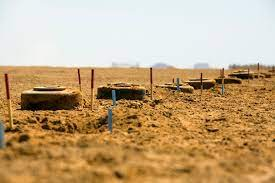

AttributeError: 'Item' object has no attribute 'driver'

In [5]:
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE


for image in images:
    image.click()

    currentUrl = Driver.driver.current_url
    time.sleep(1)
    image_element = Driver.driver.find_elements(
        By.XPATH,
        '//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div/div[3]/div[1]/a/img[1]',
    )
    print(image_element)
    print(image_element[0].get_attribute("src"))
    try:
        print(f"{os.getcwd()}")
        if not os.path.exists(f"./download/{folder}"):
            os.mkdir(f"./download/{folder}")

        http = urllib3.PoolManager(cert_reqs="CERT_NONE")
        response = http.request(
            "GET", image_element[0].get_attribute("src"), preload_content=False
        )
        with open(f"./download/{folder}/{iter}.jpg", "wb") as out_file:
            out_file.write(response.data)
        response.release_conn()
        iter += 1
    except Exception as e:
        print(e)
        pass

    item_instance = Item(currentUrl, Driver)
    children = item_instance.get_children()
    print(children)
    item_instance.download(children)